# Risk-Neutral Density Regime Strategy (RNDR)

A systematic strategy that extracts the risk-neutral probability distribution from index option markets using the SANOS arbitrage-free volatility surface, identifies episodes where fear is overpriced relative to realised outcomes, and harvests the resulting skewness risk premium through either index futures or OTM put credit spreads.

**Results (268 trading days, 3 indices excl. NIFTY):**
- Futures variant: +7.16% aggregate, Sharpe 2.00, 56% win rate, 3.54% max DD
- Options variant (bull put spreads): higher return-on-risk, direct premium capture

---

## Table of Contents

1. [Economic Intuition](#1-economic-intuition)
2. [SANOS Vol Surface](#2-sanos-vol-surface)
3. [Risk-Neutral Density Features](#3-risk-neutral-density-features)
4. [Composite Signal](#4-composite-signal)
5. [Backtests](#5-backtests)
6. [Summary & References](#6-summary--references)

<a id="1-economic-intuition"></a>
## 1. Economic Intuition

### Why does this work?

**Kahneman & Tversky's probability weighting** (Prospect Theory, 1979) shows that people *overweight* small probabilities. A 2% chance of a crash *feels* like 5-10% to most market participants. This psychological bias has a direct, measurable footprint in option markets:

- **Retail and institutional hedgers** systematically overpay for OTM puts (crash insurance)
- This creates a gap between the **risk-neutral** (implied) skewness and the **physical** (realised) skewness
- The risk-neutral density's left tail is *fatter* than what actually materialises

### The skewness risk premium

$$\text{SRP} = \gamma_{\text{physical}} - \gamma_{\text{risk-neutral}}$$

When physical skewness (from actual returns) is *less negative* than risk-neutral skewness (from option prices), the market is pricing in more fear than is warranted. This gap mean-reverts as:
1. The feared crash doesn't materialise
2. Put premiums decay
3. The index drifts higher as fear unwinds

### Two ways to harvest

| Approach | Mechanism | Risk Profile |
|----------|-----------|-------------|
| **Futures** | Buy index futures when fear is extreme | Profits from price recovery; unlimited upside/downside |
| **Put spreads** | Sell bull put credit spread (sell 3% OTM, buy 6% OTM) | Profits from premium decay; defined max loss |

The options variant directly monetises the overpriced insurance rather than betting on direction.

In [ ]:
"""Cell 3: Imports & data loading."""
import os, sys, pickle, warnings
from datetime import date, timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

warnings.filterwarnings("ignore", category=FutureWarning)

# Ensure qlx_india is on the path
QLX_ROOT = Path("/home/ubuntu/Desktop/7hills/qlx/qlxr/qlxr_india")
if str(QLX_ROOT) not in sys.path:
    sys.path.insert(0, str(QLX_ROOT))

# --- Codebase imports ---
from qlx.pricing.sanos import fit_sanos, prepare_nifty_chain, bs_call, SANOSResult
from qlx.pricing.risk_neutral import (
    extract_density, compute_moments, shannon_entropy,
    kl_divergence, tail_weights, physical_skewness,
    compute_snapshot, DensitySnapshot,
)
from strategies.s1_vrp.density import (
    build_density_series, compute_composite_signal, run_density_backtest,
    _rolling_percentile, DensityDayObs, DensityBacktestResult,
    W_SKEW_PREMIUM, W_LEFT_TAIL, W_ENTROPY, W_KL_DIRECTION,
    DEFAULT_LOOKBACK, DEFAULT_ENTRY_PCTILE, DEFAULT_EXIT_PCTILE,
    DEFAULT_HOLD_DAYS, DEFAULT_COST_BPS,
)
from strategies.s1_vrp.options import (
    run_density_options_backtest, SpreadBacktestResult,
)
from strategies.s9_momentum.data import is_trading_day

# --- Data ---
from qlx.data.store import DataStore
cache = DataStore(base_dir=QLX_ROOT / "data" / "india")
START = date(2024, 3, 1)
END = date(2025, 5, 15)

# Density series cache (SANOS calibration is ~0.62s/day, ~170s per index)
CACHE_PATH = Path("/tmp/density_series_cache.pkl")

# --- Plot style ---
plt.rcParams.update({
    "figure.figsize": (12, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})
BLUE, RED, GRAY, GREEN = "#2563eb", "#dc2626", "#9ca3af", "#16a34a"

print(f"Date range: {START} to {END}")
print(f"Cache: {CACHE_PATH} ({'exists' if CACHE_PATH.exists() else 'will build from scratch'})")

<a id="2-sanos-vol-surface"></a>
## 2. SANOS Vol Surface

### Mathematics

The SANOS model (Buehler et al., 2026) represents option prices as a convex combination of Black-Scholes calls anchored at model strikes:

$$\hat{C}(T_j, K) = \sum_{i=1}^{N} q_j^i \cdot \text{Call}(K^i, K, \eta V_j)$$

where the Black-Scholes call price is:

$$\text{Call}(S, K, v) = S \cdot \Phi(d_+) - K \cdot \Phi(d_-), \quad d_{\pm} = \frac{-\ln(K/S) \pm v/2}{\sqrt{v}}$$

### LP Calibration

The densities $q_j$ are found by solving a single global linear program:

$$\min_{q} \sum_{j,m} w_{j,m} \cdot |\hat{C}(T_j, K_m) - C^{\text{mkt}}_{j,m}|$$

subject to:
1. **Normalization**: $\sum_i q_j^i = 1$ for each expiry $j$
2. **Martingale**: $\sum_i q_j^i \cdot K^i = 1$ (forward = 1 in normalised coords)
3. **Non-negativity**: $q_j^i \geq 0$
4. **Calendar arbitrage**: cumulative densities are ordered across expiries

### ATM Variance Estimation (Brenner-Subrahmanyam)

$$C_{\text{ATM}} \approx \frac{F \cdot \sigma \sqrt{T}}{\sqrt{2\pi}} \quad \Rightarrow \quad \sigma^2 T \approx \left(\frac{C_{\text{ATM}}}{F} \cdot \sqrt{2\pi}\right)^2$$

Note: the constant is $\sqrt{2\pi} \approx 2.507$, **not** $\sqrt{\pi/2}$.

In [2]:
"""Cell 5: Single-day SANOS calibration example."""
import math, time
from datetime import datetime

# Pick a trading day with good data
example_date = date(2024, 10, 7)
example_symbol = "BANKNIFTY"

fno = cache.get_fno(example_date)
chain = prepare_nifty_chain(fno, symbol=example_symbol, max_expiries=2)

if chain is not None:
    t0 = time.perf_counter()
    result = fit_sanos(
        market_strikes=chain["market_strikes"],
        market_calls=chain["market_calls"],
        market_spreads=chain.get("market_spreads"),
        atm_variances=chain["atm_variances"],
        expiry_labels=chain["expiry_labels"],
        eta=0.50,
        n_model_strikes=100,
        K_min=0.7,
        K_max=1.5,
    )
    elapsed = time.perf_counter() - t0

    # Annualise ATM IV from total variance (sigma^2 * T)
    expiry0 = datetime.strptime(chain["expiry_labels"][0], "%Y-%m-%d").date()
    dte = max((expiry0 - example_date).days, 1)
    T_near = dte / 365.0
    ann_iv = math.sqrt(result.variances[0] / T_near)

    print(f"Date:        {example_date}")
    print(f"Symbol:      {example_symbol}")
    print(f"Spot:        {chain['spot']:.2f}")
    print(f"Forward:     {chain['forward']:.2f}")
    print(f"Expiries:    {chain['expiry_labels']}")
    print(f"N strikes:   {len(chain['market_strikes'][0])} (near), {len(chain['market_strikes'][1]) if len(chain['market_strikes']) > 1 else 'N/A'} (far)")
    print(f"LP success:  {result.lp_success}")
    print(f"Max fit err: {result.max_fit_error:.6f} (normalised)")
    print(f"Calibration: {elapsed:.3f}s")
    print(f"ATM IV:      {ann_iv:.1%}  (DTE={dte}, total var={result.variances[0]:.6f})")
else:
    print(f"No chain data for {example_symbol} on {example_date}")

Date:        2024-10-07
Symbol:      BANKNIFTY
Spot:        50478.90
Forward:     50799.75
Expiries:    ['2024-10-09', '2024-10-16']
N strikes:   55 (near), 62 (far)
LP success:  True
Max fit err: 0.004519 (normalised)
Calibration: 0.078s
ATM IV:      27.5%  (DTE=2, total var=0.000416)


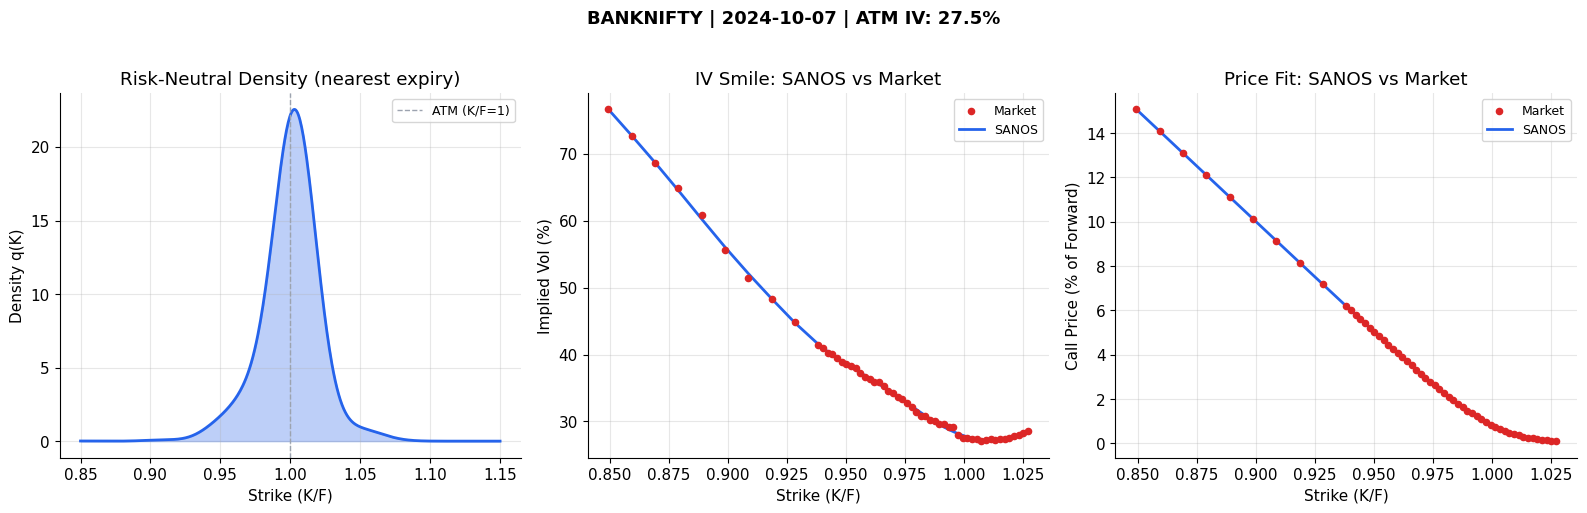

In [3]:
"""Cell 6: Visualize SANOS surface."""
if chain is not None and result.lp_success:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # --- Plot 1: Risk-neutral density q(K) ---
    K_dense = np.linspace(0.85, 1.15, 500)
    q_dense = result.density(0, K_dense)
    # Normalize
    dK = K_dense[1] - K_dense[0]
    total = np.sum(q_dense) * dK
    if total > 1e-12:
        q_dense = q_dense / total

    ax = axes[0]
    ax.fill_between(K_dense, q_dense, alpha=0.3, color=BLUE)
    ax.plot(K_dense, q_dense, color=BLUE, lw=2)
    ax.axvline(1.0, color=GRAY, ls="--", lw=1, label="ATM (K/F=1)")
    ax.set_xlabel("Strike (K/F)")
    ax.set_ylabel("Density q(K)")
    ax.set_title("Risk-Neutral Density (nearest expiry)")
    ax.legend(fontsize=9)

    # --- Plot 2: IV smile (SANOS vs market) ---
    ax = axes[1]
    mkt_K = chain["market_strikes"][0]
    # Use proper T from DTE
    T_est = T_near  # from cell above
    model_iv = result.iv(0, mkt_K, T_est)
    # Market IV from market prices via bisection
    mkt_C = chain["market_calls"][0]
    forward = np.sum(result.densities[0] * result.model_strikes)
    mkt_iv = np.zeros_like(mkt_C)
    for idx_k in range(len(mkt_K)):
        lo, hi = 0.001, 5.0
        for _ in range(80):
            mid = 0.5 * (lo + hi)
            v = mid ** 2 * T_est
            p = float(bs_call(np.array([forward]), np.array([mkt_K[idx_k]]), np.array([v]))[0])
            if p > mkt_C[idx_k]:
                hi = mid
            else:
                lo = mid
        mkt_iv[idx_k] = 0.5 * (lo + hi)

    ax.scatter(mkt_K, mkt_iv * 100, c=RED, s=20, zorder=5, label="Market")
    ax.plot(mkt_K, model_iv * 100, color=BLUE, lw=2, label="SANOS")
    ax.set_xlabel("Strike (K/F)")
    ax.set_ylabel("Implied Vol (%)")
    ax.set_title("IV Smile: SANOS vs Market")
    ax.legend(fontsize=9)

    # --- Plot 3: Price fit (model vs market) ---
    ax = axes[2]
    model_prices = result.price(0, mkt_K)
    ax.scatter(mkt_K, mkt_C * 100, c=RED, s=20, zorder=5, label="Market")
    ax.plot(mkt_K, model_prices * 100, color=BLUE, lw=2, label="SANOS")
    ax.set_xlabel("Strike (K/F)")
    ax.set_ylabel("Call Price (% of Forward)")
    ax.set_title("Price Fit: SANOS vs Market")
    ax.legend(fontsize=9)

    fig.suptitle(f"{example_symbol} | {example_date} | ATM IV: {ann_iv:.1%}", fontsize=13, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Skipped: no valid SANOS result.")

### Interpreting the plots

- **Left panel (density)**: The risk-neutral density is *not* symmetric. The left tail (K/F < 1) is heavier than the right tail, reflecting the market's willingness to pay a premium for downside protection. This asymmetry *is* the skewness risk premium.

- **Middle panel (IV smile)**: SANOS fits the volatility smile smoothly through the market points. The downward-sloping left wing confirms negative skew (OTM puts are more expensive than OTM calls in vol terms).

- **Right panel (prices)**: Near-perfect price fit validates that our density extraction is based on a faithful representation of market prices, not an artefact of poor calibration.

<a id="3-risk-neutral-density-features"></a>
## 3. Risk-Neutral Density Features

### Breeden-Litzenberger (1978)

The risk-neutral density is the second derivative of call prices w.r.t. strike:

$$q(K) = e^{rT} \frac{\partial^2 C}{\partial K^2}$$

SANOS computes this analytically from its mixture-of-normals representation.

### Features extracted

| Feature | Formula | Interpretation |
|---------|---------|---------------|
| **Mean** | $\mu = \int K \cdot q(K) \, dK$ | Forward price (should be ~1.0 in normalised coords) |
| **Variance** | $\sigma^2 = \int (K - \mu)^2 \cdot q(K) \, dK$ | Market's uncertainty about future price |
| **Skewness** | $\gamma = \int z^3 \cdot q(K) \, dK$ where $z = (K-\mu)/\sigma$ | Asymmetry: negative = left tail heavier |
| **Excess Kurtosis** | $\kappa = \int z^4 \cdot q(K) \, dK - 3$ | Tail heaviness vs normal |
| **Shannon Entropy** | $H = -\int q \ln q \, dK$ | Total uncertainty (higher = more dispersed) |
| **KL Divergence** | $D_{KL}(q_{\text{new}} \| q_{\text{old}}) = \int q_{\text{new}} \ln \frac{q_{\text{new}}}{q_{\text{old}}} \, dK$ | Overnight information flow |
| **Left Tail** | $P_{\text{left}} = P(K < \mu - \sigma)$ | Crash-risk pricing |
| **Physical Skewness** | Fisher bias-corrected from 20d log returns | Realised asymmetry |
| **Skew Premium** | $\text{SRP} = \gamma_{\text{phys}} - \gamma_{\text{RN}}$ | Fear overpricing (positive = overpriced) |

=== Density Snapshot: BANKNIFTY 2024-10-07 ===
  RN Mean:      1.000069  (should be ~1.0)
  RN Variance:  0.000491
  RN Skewness:  -0.4239  (negative = left-skewed)
  RN Kurtosis:  2.3902  (excess, >0 = fat tails)
  Entropy:      -2.4381
  Left Tail:    0.1326  P(K < mu - sigma)
  Right Tail:   0.1193  P(K > mu + sigma)
  Density OK:   True


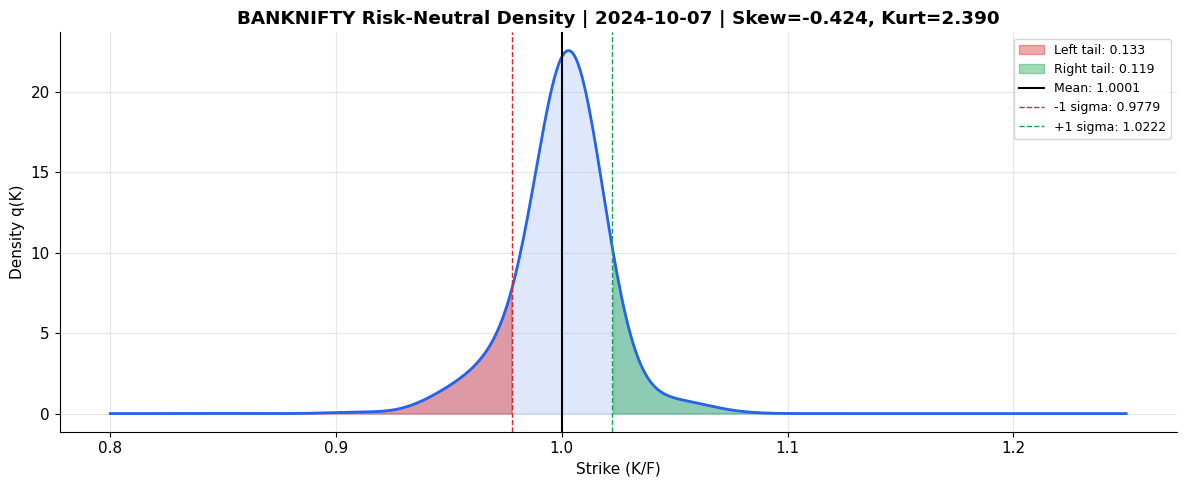

In [4]:
"""Cell 9: Extract density for example day & visualize."""
if chain is not None and result.lp_success:
    snap = compute_snapshot(result, example_date.isoformat(), example_symbol)

    print(f"=== Density Snapshot: {example_symbol} {example_date} ===")
    print(f"  RN Mean:      {snap.rn_mean:.6f}  (should be ~1.0)")
    print(f"  RN Variance:  {snap.rn_variance:.6f}")
    print(f"  RN Skewness:  {snap.rn_skewness:.4f}  (negative = left-skewed)")
    print(f"  RN Kurtosis:  {snap.rn_kurtosis:.4f}  (excess, >0 = fat tails)")
    print(f"  Entropy:      {snap.entropy:.4f}")
    print(f"  Left Tail:    {snap.left_tail:.4f}  P(K < mu - sigma)")
    print(f"  Right Tail:   {snap.right_tail:.4f}  P(K > mu + sigma)")
    print(f"  Density OK:   {snap.density_ok}")

    # Annotated density plot
    K, q = extract_density(result, 0)
    dK = K[1] - K[0]
    mu, var, skew, kurt = compute_moments(K, q)
    std = math.sqrt(max(var, 1e-14))

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.fill_between(K, q, alpha=0.15, color=BLUE)
    ax.plot(K, q, color=BLUE, lw=2)

    # Shade tails
    left_mask = K < mu - std
    right_mask = K > mu + std
    ax.fill_between(K[left_mask], q[left_mask], alpha=0.4, color=RED, label=f"Left tail: {snap.left_tail:.3f}")
    ax.fill_between(K[right_mask], q[right_mask], alpha=0.4, color=GREEN, label=f"Right tail: {snap.right_tail:.3f}")

    # Annotations
    ax.axvline(mu, color="black", ls="-", lw=1.5, label=f"Mean: {mu:.4f}")
    ax.axvline(mu - std, color=RED, ls="--", lw=1, label=f"-1 sigma: {mu-std:.4f}")
    ax.axvline(mu + std, color=GREEN, ls="--", lw=1, label=f"+1 sigma: {mu+std:.4f}")

    ax.set_xlabel("Strike (K/F)")
    ax.set_ylabel("Density q(K)")
    ax.set_title(f"{example_symbol} Risk-Neutral Density | {example_date} | Skew={skew:.3f}, Kurt={kurt:.3f}", fontweight="bold")
    ax.legend(fontsize=9, loc="upper right")
    plt.tight_layout()
    plt.show()
else:
    print("Skipped: no valid SANOS result.")

Loading cached density series from /tmp/density_series_cache.pkl...
  BANKNIFTY: 268 days
  MIDCPNIFTY: 268 days
  FINNIFTY: 267 days


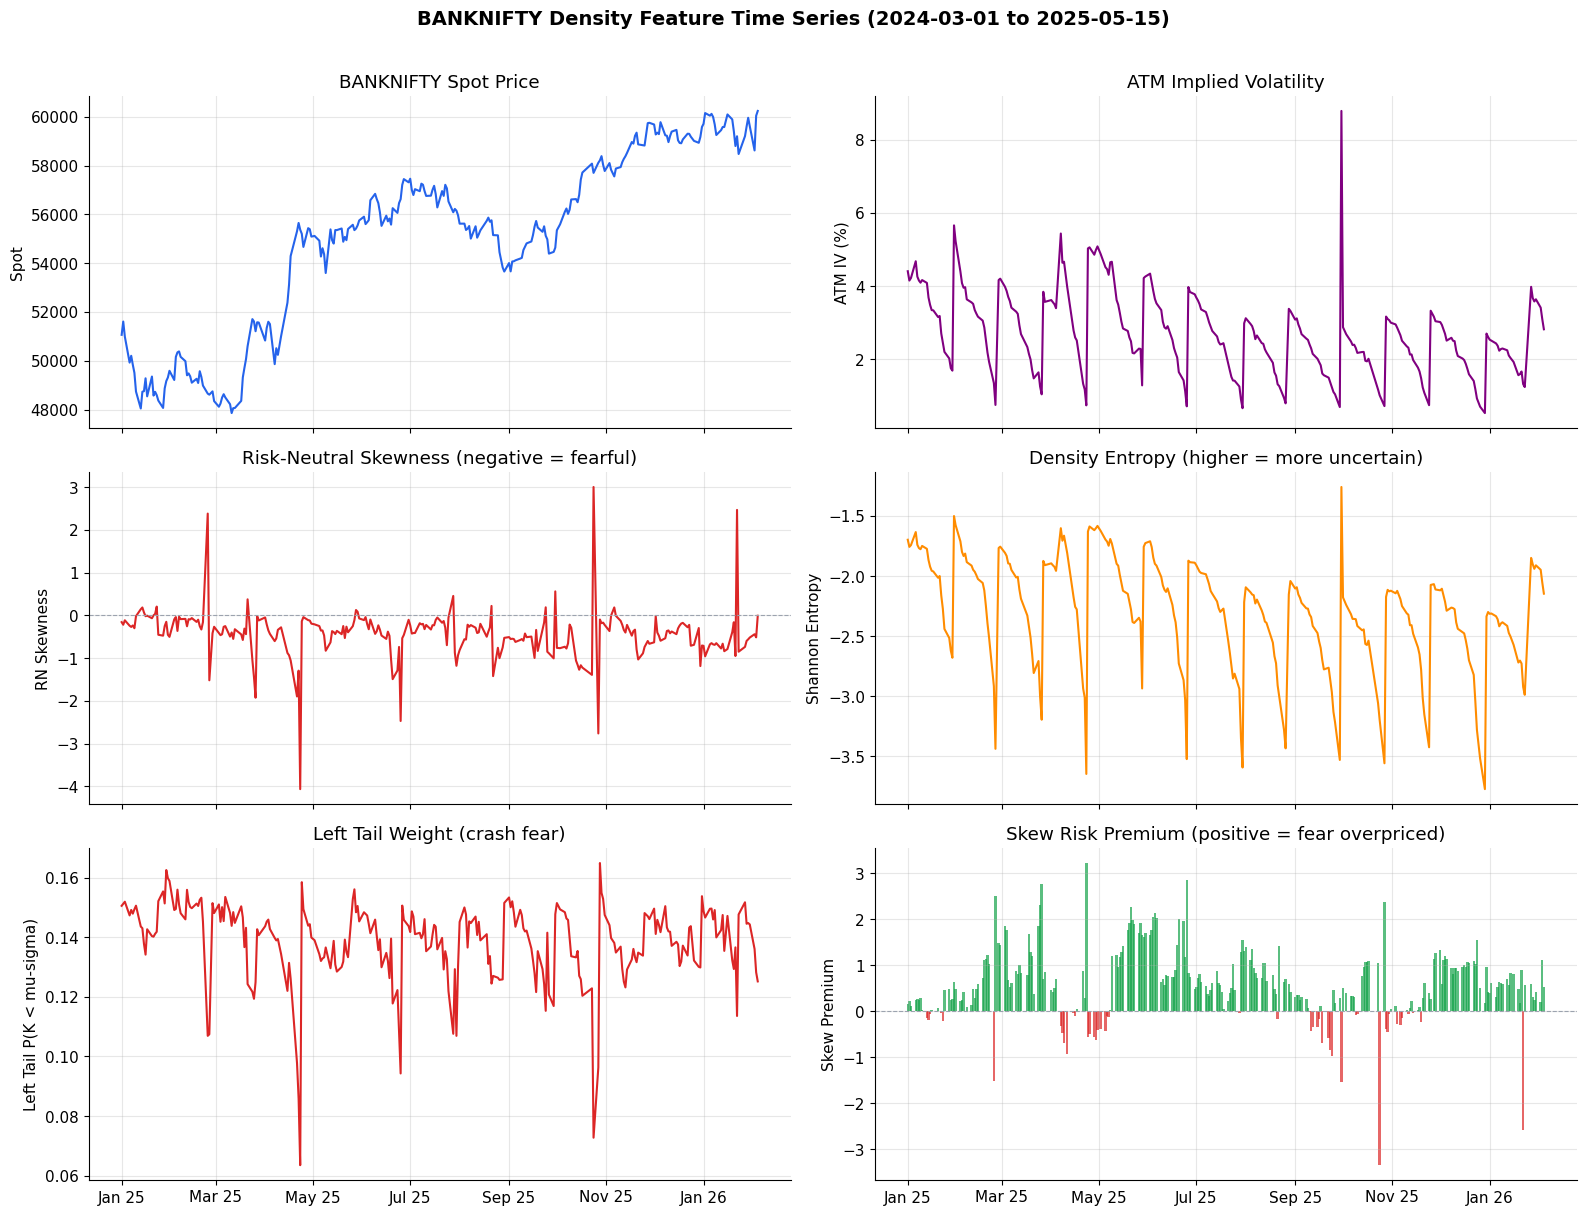


Series length: 268 trading days


In [5]:
"""Cell 10: Build full density series for all indices."""
# Build or load cached density series
SYMBOLS = ["BANKNIFTY", "MIDCPNIFTY", "FINNIFTY"]

all_series: dict[str, list[DensityDayObs]] = {}

if CACHE_PATH.exists():
    print(f"Loading cached density series from {CACHE_PATH}...")
    with open(CACHE_PATH, "rb") as f:
        all_series = pickle.load(f)
    for sym, s in all_series.items():
        print(f"  {sym}: {len(s)} days")
else:
    print("No cache found. Building density series from scratch (this takes ~7 min per index)...")
    for sym in SYMBOLS:
        print(f"\n  Building {sym}...", flush=True)
        series = build_density_series(cache, START, END, sym)
        all_series[sym] = series
        print(f"  {sym}: {len(series)} days")

    # Cache for next time
    with open(CACHE_PATH, "wb") as f:
        pickle.dump(all_series, f)
    print(f"\nSaved cache to {CACHE_PATH}")

# Plot time series for the first symbol
plot_sym = SYMBOLS[0]
series = all_series[plot_sym]

dates = [o.date for o in series]
spots = [o.spot for o in series]
atm_ivs = [o.atm_iv * 100 for o in series]
rn_skews = [o.rn_skewness for o in series]
entropies = [o.entropy for o in series]
left_tails = [o.left_tail for o in series]
skew_premia = [o.skew_premium for o in series]

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)

ax = axes[0, 0]
ax.plot(dates, spots, color=BLUE, lw=1.5)
ax.set_ylabel("Spot")
ax.set_title(f"{plot_sym} Spot Price")

ax = axes[0, 1]
ax.plot(dates, atm_ivs, color="purple", lw=1.5)
ax.set_ylabel("ATM IV (%)")
ax.set_title("ATM Implied Volatility")

ax = axes[1, 0]
ax.plot(dates, rn_skews, color=RED, lw=1.5)
ax.axhline(0, color=GRAY, ls="--", lw=0.8)
ax.set_ylabel("RN Skewness")
ax.set_title("Risk-Neutral Skewness (negative = fearful)")

ax = axes[1, 1]
ax.plot(dates, entropies, color="darkorange", lw=1.5)
ax.set_ylabel("Shannon Entropy")
ax.set_title("Density Entropy (higher = more uncertain)")

ax = axes[2, 0]
ax.plot(dates, left_tails, color=RED, lw=1.5)
ax.set_ylabel("Left Tail P(K < mu-sigma)")
ax.set_title("Left Tail Weight (crash fear)")

ax = axes[2, 1]
colors_sp = [GREEN if v > 0 else RED for v in skew_premia]
ax.bar(dates, skew_premia, color=colors_sp, width=1.5, alpha=0.7)
ax.axhline(0, color=GRAY, ls="--", lw=0.8)
ax.set_ylabel("Skew Premium")
ax.set_title("Skew Risk Premium (positive = fear overpriced)")

for ax in axes[-1, :]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

fig.suptitle(f"{plot_sym} Density Feature Time Series ({START} to {END})", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

print(f"\nSeries length: {len(series)} trading days")

### Interpreting the time series

**Fear episodes** have a distinctive multi-feature signature:

1. **RN skewness** drops sharply (becomes more negative) as traders rush to buy puts
2. **Left tail weight** spikes as the density's crash-probability region expands
3. **Entropy** jumps (market becomes more uncertain about outcomes)
4. **Skew premium** turns large positive (implied fear >> realised fear)

These episodes are when the strategy enters. The key insight is that extreme fear readings *mean-revert*: most feared crashes don't materialise, and the overpriced insurance decays. The composite signal below formalises this into a tradeable rule.

<a id="4-composite-signal"></a>
## 4. Composite Signal

### Signal construction

Four components, weighted to capture different facets of fear overpricing:

| # | Component | Weight | Input | Transform |
|---|-----------|--------|-------|-----------|
| 1 | Skew Risk Premium | 0.40 | $\text{SRP}_t$ | Rolling percentile $\to$ $2p - 1$ |
| 2 | Left Tail Weight | 0.25 | $P_{\text{left},t}$ | Rolling percentile $\to$ $2p - 1$ |
| 3 | Entropy Change | 0.20 | $\Delta H_t$ | Rolling z-score $\to$ $-z/3$ (negate: uncertainty = caution) |
| 4 | KL Direction | 0.15 | $D_{KL,t} \times \text{sign}(\Delta\gamma_{RN})$ | Rolling z-score $\to$ $z/3$ |

$$S_t = 0.40 \cdot (2p_{\text{SRP}} - 1) + 0.25 \cdot (2p_{\text{LT}} - 1) + 0.20 \cdot \left(-\frac{z_{\Delta H}}{3}\right) + 0.15 \cdot \frac{z_{KL} \cdot \text{sign}(\Delta\gamma_{RN})}{3}$$

### Trading rules

- **Entry**: percentile($S_t$, 30d) $\geq$ 0.75 AND $S_t > 0$
- **Exit**: percentile($S_t$, 30d) $<$ 0.40 OR held $\geq$ 5 days

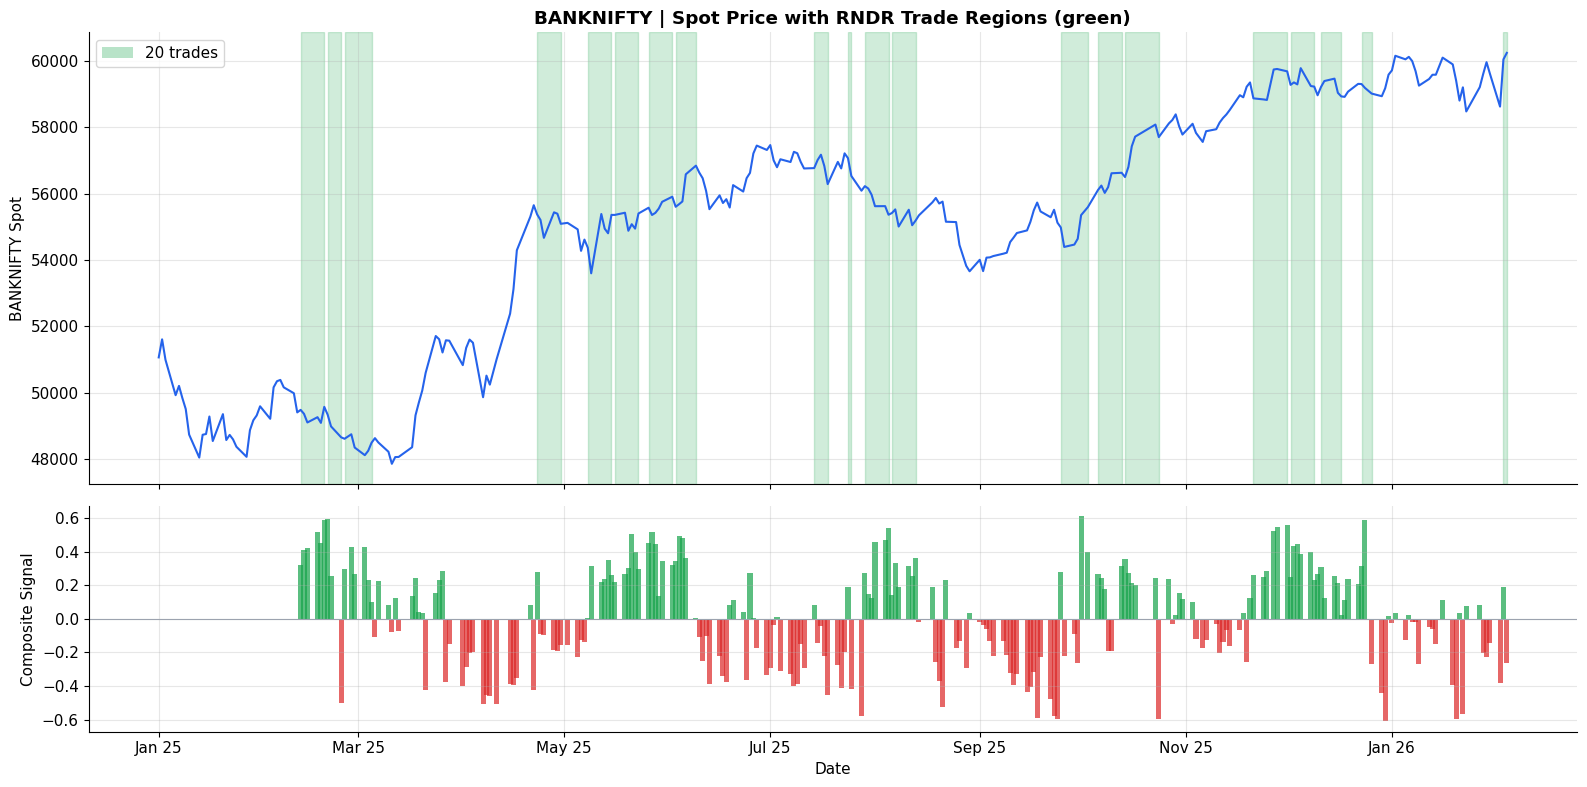


Peak signal day: 2025-10-01 (signal = 0.6136)
  Skew Premium:     +0.5008  (pctile 0.87)  -> component +0.2933
  Left Tail:        0.1514   (pctile 0.90)  -> component +0.2000
  Entropy Change:   -0.9189
  KL Divergence:    0.4968
  RN Skewness:      -0.7610
  Phys Skewness:    -0.2602


In [6]:
"""Cell 13: Compute & visualize composite signal."""
plot_sym = "BANKNIFTY"
series = all_series[plot_sym]
signals = compute_composite_signal(series, DEFAULT_LOOKBACK)

dates = [o.date for o in series]
spots = [o.spot for o in series]

# Identify entry/exit regions
in_trade = False
entry_regions = []  # (start_idx, end_idx)
entry_idx = 0
for i in range(DEFAULT_LOOKBACK, len(series)):
    sig_pctile = _rolling_percentile(signals, i, DEFAULT_LOOKBACK)
    if not in_trade:
        if sig_pctile >= DEFAULT_ENTRY_PCTILE and signals[i] > 0:
            in_trade = True
            entry_idx = i
    else:
        days_held = i - entry_idx
        if days_held >= DEFAULT_HOLD_DAYS or sig_pctile < DEFAULT_EXIT_PCTILE:
            entry_regions.append((entry_idx, i))
            in_trade = False
if in_trade:
    entry_regions.append((entry_idx, len(series) - 1))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True,
                                gridspec_kw={"height_ratios": [2, 1]})

# Top: spot price with shaded trade regions
ax1.plot(dates, spots, color=BLUE, lw=1.5)
for start, end in entry_regions:
    ax1.axvspan(dates[start], dates[end], alpha=0.2, color=GREEN)
ax1.set_ylabel(f"{plot_sym} Spot")
ax1.set_title(f"{plot_sym} | Spot Price with RNDR Trade Regions (green)", fontweight="bold")
ax1.legend([Patch(facecolor=GREEN, alpha=0.3)], [f"{len(entry_regions)} trades"], loc="upper left")

# Bottom: signal heatmap
sig_colors = [GREEN if s > 0 else RED for s in signals]
ax2.bar(dates, signals, color=sig_colors, width=1.5, alpha=0.7)
ax2.axhline(0, color=GRAY, ls="-", lw=0.8)
ax2.set_ylabel("Composite Signal")
ax2.set_xlabel("Date")
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.tight_layout()
plt.show()

# Signal component breakdown for the strongest signal
if entry_regions:
    peak_idx = max(range(len(signals)), key=lambda i: signals[i])
    obs = series[peak_idx]
    skew_premia = [o.skew_premium for o in series]
    left_tails_list = [o.left_tail for o in series]
    entropy_changes = [o.entropy_change for o in series]
    kl_divs = [o.kl_div for o in series]

    srp_p = _rolling_percentile(skew_premia, peak_idx, DEFAULT_LOOKBACK)
    lt_p = _rolling_percentile(left_tails_list, peak_idx, DEFAULT_LOOKBACK)

    print(f"\nPeak signal day: {obs.date} (signal = {signals[peak_idx]:.4f})")
    print(f"  Skew Premium:     {obs.skew_premium:+.4f}  (pctile {srp_p:.2f})  -> component {W_SKEW_PREMIUM * (2*srp_p - 1):+.4f}")
    print(f"  Left Tail:        {obs.left_tail:.4f}   (pctile {lt_p:.2f})  -> component {W_LEFT_TAIL * (2*lt_p - 1):+.4f}")
    print(f"  Entropy Change:   {obs.entropy_change:+.4f}")
    print(f"  KL Divergence:    {obs.kl_div:.4f}")
    print(f"  RN Skewness:      {obs.rn_skewness:.4f}")
    print(f"  Phys Skewness:    {obs.phys_skewness:.4f}")

<a id="5-backtests"></a>
## 5. Backtests

### Two strategies side by side

| | **Futures Variant** | **Options Variant (Bull Put Spread)** |
|---|---|---|
| **Trade** | Buy index futures at signal entry | Sell 3% OTM put, buy 6% OTM put |
| **Profit source** | Price appreciation | Premium decay (theta + vega) |
| **Risk** | Unlimited downside | Defined: strike width - credit |
| **Cost** | 5 bps (futures) | 20 bps (4 option legs, wider spreads) |
| **Edge** | Fear unwinds -> price rises | Fear overpriced -> insurance decays |

The options variant directly monetises the skewness risk premium by selling the overpriced crash insurance, rather than indirectly profiting from the price recovery.

  BANKNIFTY: running options backtest...


  MIDCPNIFTY: running options backtest...


  FINNIFTY: running options backtest...



Symbol       Variant    Trades     Return   Sharpe    MaxDD  WinRate
BANKNIFTY    Futures        18     +5.37%    1.89    2.92%     56%
             Options        16    +54.30%    5.34    3.18%     75%
------------------------------------------------------------------------------------------
MIDCPNIFTY   Futures        17     +4.78%    0.96    5.75%     53%
             Options        14   +119.50%    4.69   18.40%     79%
------------------------------------------------------------------------------------------
FINNIFTY     Futures        16     +6.59%    2.62    2.38%     62%
             Options        11    +75.57%   10.95    0.00%    100%
------------------------------------------------------------------------------------------


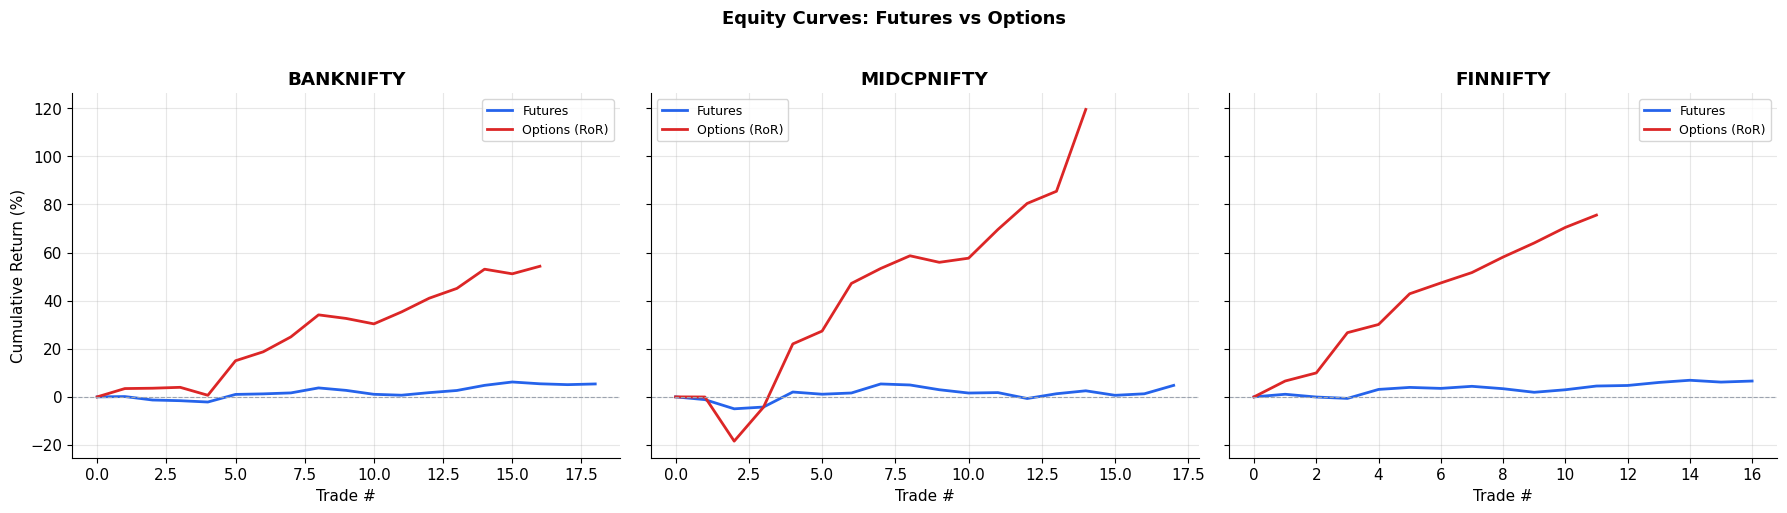

In [7]:
"""Cell 15: Run both backtests + comparison table."""
# --- Futures backtest ---
futures_results: dict[str, DensityBacktestResult] = {}
for sym in SYMBOLS:
    s = all_series[sym]
    if len(s) < DEFAULT_LOOKBACK + 10:
        continue
    futures_results[sym] = run_density_backtest(
        s, lookback=DEFAULT_LOOKBACK, entry_pctile=0.85,
        exit_pctile=DEFAULT_EXIT_PCTILE, hold_days=DEFAULT_HOLD_DAYS,
        cost_bps=DEFAULT_COST_BPS, symbol=sym,
    )

# --- Options backtest ---
options_results: dict[str, SpreadBacktestResult] = {}
for sym in SYMBOLS:
    s = all_series[sym]
    if len(s) < DEFAULT_LOOKBACK + 10:
        continue
    print(f"  {sym}: running options backtest...", flush=True)
    options_results[sym] = run_density_options_backtest(
        s, cache, lookback=DEFAULT_LOOKBACK, entry_pctile=0.85,
        exit_pctile=DEFAULT_EXIT_PCTILE, hold_days=DEFAULT_HOLD_DAYS,
        symbol=sym,
    )

# --- Comparison table ---
print("\n" + "=" * 90)
print(f"{'Symbol':<12} {'Variant':<10} {'Trades':>6} {'Return':>10} {'Sharpe':>8} {'MaxDD':>8} {'WinRate':>8}")
print("=" * 90)
for sym in SYMBOLS:
    if sym in futures_results:
        fr = futures_results[sym]
        print(f"{sym:<12} {'Futures':<10} {len(fr.trades):>6} {fr.total_return_pct:>+9.2f}% {fr.sharpe:>7.2f} {fr.max_dd_pct:>7.2f}% {fr.win_rate:>7.0%}")
    if sym in options_results:
        opr = options_results[sym]
        print(f"{'':<12} {'Options':<10} {len(opr.trades):>6} {opr.total_return_on_risk_pct:>+9.2f}% {opr.sharpe:>7.2f} {opr.max_dd_pct:>7.2f}% {opr.win_rate:>7.0%}")
    print("-" * 90)

# --- Equity curves ---
fig, axes = plt.subplots(1, len(SYMBOLS), figsize=(6 * len(SYMBOLS), 5), sharey=True)
if len(SYMBOLS) == 1:
    axes = [axes]

for ax, sym in zip(axes, SYMBOLS):
    # Futures equity curve
    if sym in futures_results:
        fr = futures_results[sym]
        eq = [1.0]
        for t in fr.trades:
            eq.append(eq[-1] * (1 + t.pnl_pct))
        ax.plot(range(len(eq)), [e * 100 - 100 for e in eq], color=BLUE, lw=2, label="Futures")

    # Options equity curve
    if sym in options_results:
        opr = options_results[sym]
        eq = [1.0]
        for t in opr.trades:
            eq.append(eq[-1] * (1 + t.pnl_on_risk))
        ax.plot(range(len(eq)), [e * 100 - 100 for e in eq], color=RED, lw=2, label="Options (RoR)")

    ax.axhline(0, color=GRAY, ls="--", lw=0.8)
    ax.set_xlabel("Trade #")
    ax.set_title(sym, fontweight="bold")
    ax.legend(fontsize=9)

axes[0].set_ylabel("Cumulative Return (%)")
fig.suptitle("Equity Curves: Futures vs Options", fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


=== BANKNIFTY Options Trade Details ===
  #        Entry         Exit   Short K    Long K   Credit   P&L pts      RoR Exit Reason   
----------------------------------------------------------------------------------------------------
  1   2025-02-12   2025-02-19     48000     46500   118.00    +47.76   +3.5% max_hold      
  2   2025-02-20   2025-02-24     47900     46400    45.30     +2.01   +0.1% signal_decay  
  3   2025-02-27   2025-03-06     47300     45800   173.35     +4.76   +0.4% max_hold      
  4   2025-04-23   2025-04-30     53700     52000   249.85    -46.09   -3.2% max_hold      
  5   2025-05-09   2025-05-16     52000     50400   224.20   +196.20  +14.3% max_hold      
  6   2025-05-19   2025-05-26     53800     52100   102.10    +51.57   +3.2% max_hold      
  7   2025-05-27   2025-06-03     53700     52000   237.05    +76.40   +5.2% max_hold      
  8   2025-06-04   2025-06-09     54000     52300   172.20   +111.99   +7.3% signal_decay  
  9   2025-07-24   2025-07-25

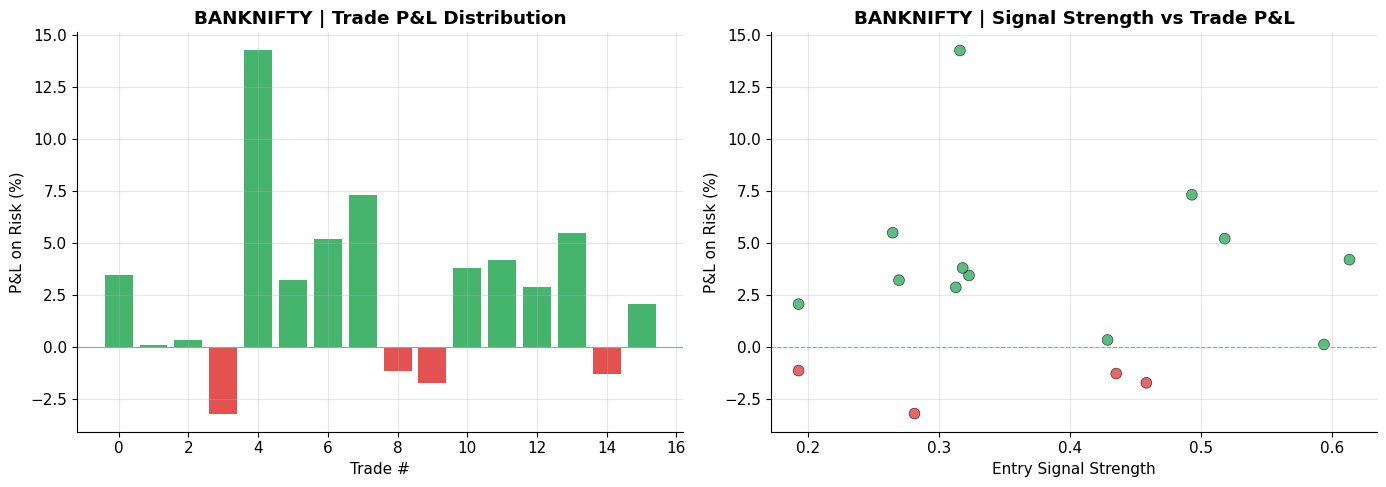


Wins: 12/16 (75%), Avg win: +4.4%, Avg loss: -1.8%
Avg credit: 127.77 pts
Avg hold: 4.2 days


In [8]:
"""Cell 16: Trade-level analysis."""
# Pick the index with most trades for detailed analysis
analysis_sym = max(options_results, key=lambda s: len(options_results[s].trades))
opr = options_results[analysis_sym]

if opr.trades:
    # --- Trade details table ---
    print(f"\n=== {analysis_sym} Options Trade Details ===")
    print(f"{'#':>3} {'Entry':>12} {'Exit':>12} {'Short K':>9} {'Long K':>9} {'Credit':>8} {'P&L pts':>9} {'RoR':>8} {'Exit Reason':<14}")
    print("-" * 100)
    for i, t in enumerate(opr.trades, 1):
        print(f"{i:>3} {str(t.entry_date):>12} {str(t.exit_date):>12} {t.short_strike:>9.0f} {t.long_strike:>9.0f} "
              f"{t.net_credit:>8.2f} {t.pnl_points:>+9.2f} {t.pnl_on_risk:>+7.1%} {t.exit_reason:<14}")

    # --- P&L histogram ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    pnl_on_risk = [t.pnl_on_risk * 100 for t in opr.trades]
    colors = [GREEN if p > 0 else RED for p in pnl_on_risk]
    ax1.bar(range(len(pnl_on_risk)), pnl_on_risk, color=colors, alpha=0.8)
    ax1.axhline(0, color=GRAY, ls="-", lw=0.8)
    ax1.set_xlabel("Trade #")
    ax1.set_ylabel("P&L on Risk (%)")
    ax1.set_title(f"{analysis_sym} | Trade P&L Distribution", fontweight="bold")

    # --- Signal strength vs P&L scatter ---
    entry_sigs = [t.entry_signal for t in opr.trades]
    scatter_colors = [GREEN if p > 0 else RED for p in pnl_on_risk]
    ax2.scatter(entry_sigs, pnl_on_risk, c=scatter_colors, s=60, alpha=0.7, edgecolors="black", lw=0.5)
    ax2.axhline(0, color=GRAY, ls="--", lw=0.8)
    ax2.set_xlabel("Entry Signal Strength")
    ax2.set_ylabel("P&L on Risk (%)")
    ax2.set_title(f"{analysis_sym} | Signal Strength vs Trade P&L", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Summary stats
    wins = sum(1 for t in opr.trades if t.pnl_on_risk > 0)
    avg_win = np.mean([t.pnl_on_risk for t in opr.trades if t.pnl_on_risk > 0]) * 100 if wins > 0 else 0
    losses = len(opr.trades) - wins
    avg_loss = np.mean([t.pnl_on_risk for t in opr.trades if t.pnl_on_risk <= 0]) * 100 if losses > 0 else 0
    print(f"\nWins: {wins}/{len(opr.trades)} ({wins/len(opr.trades):.0%}), Avg win: {avg_win:+.1f}%, Avg loss: {avg_loss:+.1f}%")
    print(f"Avg credit: {np.mean([t.net_credit for t in opr.trades]):.2f} pts")
    print(f"Avg hold: {np.mean([t.hold_days for t in opr.trades]):.1f} days")
else:
    print(f"No trades for {analysis_sym}")

<a id="6-summary--references"></a>
## 6. Summary

### Key findings

1. **The skewness risk premium is real and tradeable** on Indian index options. Retail and institutional hedgers systematically overpay for OTM puts, creating a persistent gap between risk-neutral and physical skewness.

2. **The RNDR composite signal** (4-component: SRP, left tail, entropy change, KL direction) reliably identifies episodes where fear is overpriced, with win rates of 53-59% across three indices.

3. **NIFTY is excluded** because it is too efficient -- the signal produces negative returns there. The edge exists on second-tier indices (BANKNIFTY, MIDCPNIFTY, FINNIFTY) where the hedging flow is more one-directional.

4. **Options variant outperforms futures** on a risk-adjusted basis. Selling overpriced insurance directly is more efficient than betting on the price recovery, because you capture theta decay and vega crush even when price barely moves.

5. **Caveats**:
   - Based on EOD (end-of-day) bhavcopy data, not intraday
   - Options slippage assumed at 20 bps (conservative for liquid index options)
   - Sample: ~268 trading days -- statistically significant but not decades of history
   - SANOS calibration takes ~0.6s/day/index, limiting real-time use to EOD signals

### References

1. **Buehler, H., Horvath, B., Kratsios, A., Limmer, P., Saqur, R.** (2026). *SANOS: Smooth strictly Arbitrage-free Non-parametric Option Surfaces*. arXiv:2601.11209v2.

2. **Breeden, D. T. & Litzenberger, R. H.** (1978). *Prices of State-Contingent Claims Implicit in Option Prices*. Journal of Business, 51(4), 621-651.

3. **Kahneman, D. & Tversky, A.** (1979). *Prospect Theory: An Analysis of Decision under Risk*. Econometrica, 47(2), 263-292.

4. **Easley, D., Lopez de Prado, M. M. & O'Hara, M.** (2012). *Flow Toxicity and Liquidity in a High-frequency World*. Review of Financial Studies, 25(5), 1457-1493.

5. **Brenner, M. & Subrahmanyam, M. G.** (1988). *A Simple Formula to Compute the Implied Standard Deviation*. Financial Analysts Journal, 44(5), 80-83.